In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

/tmp/ipykernel_11659/2839428726.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


In [2]:
housing = load_housing_data()
housing.head()

/tmp/ipykernel_11659/2839428726.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


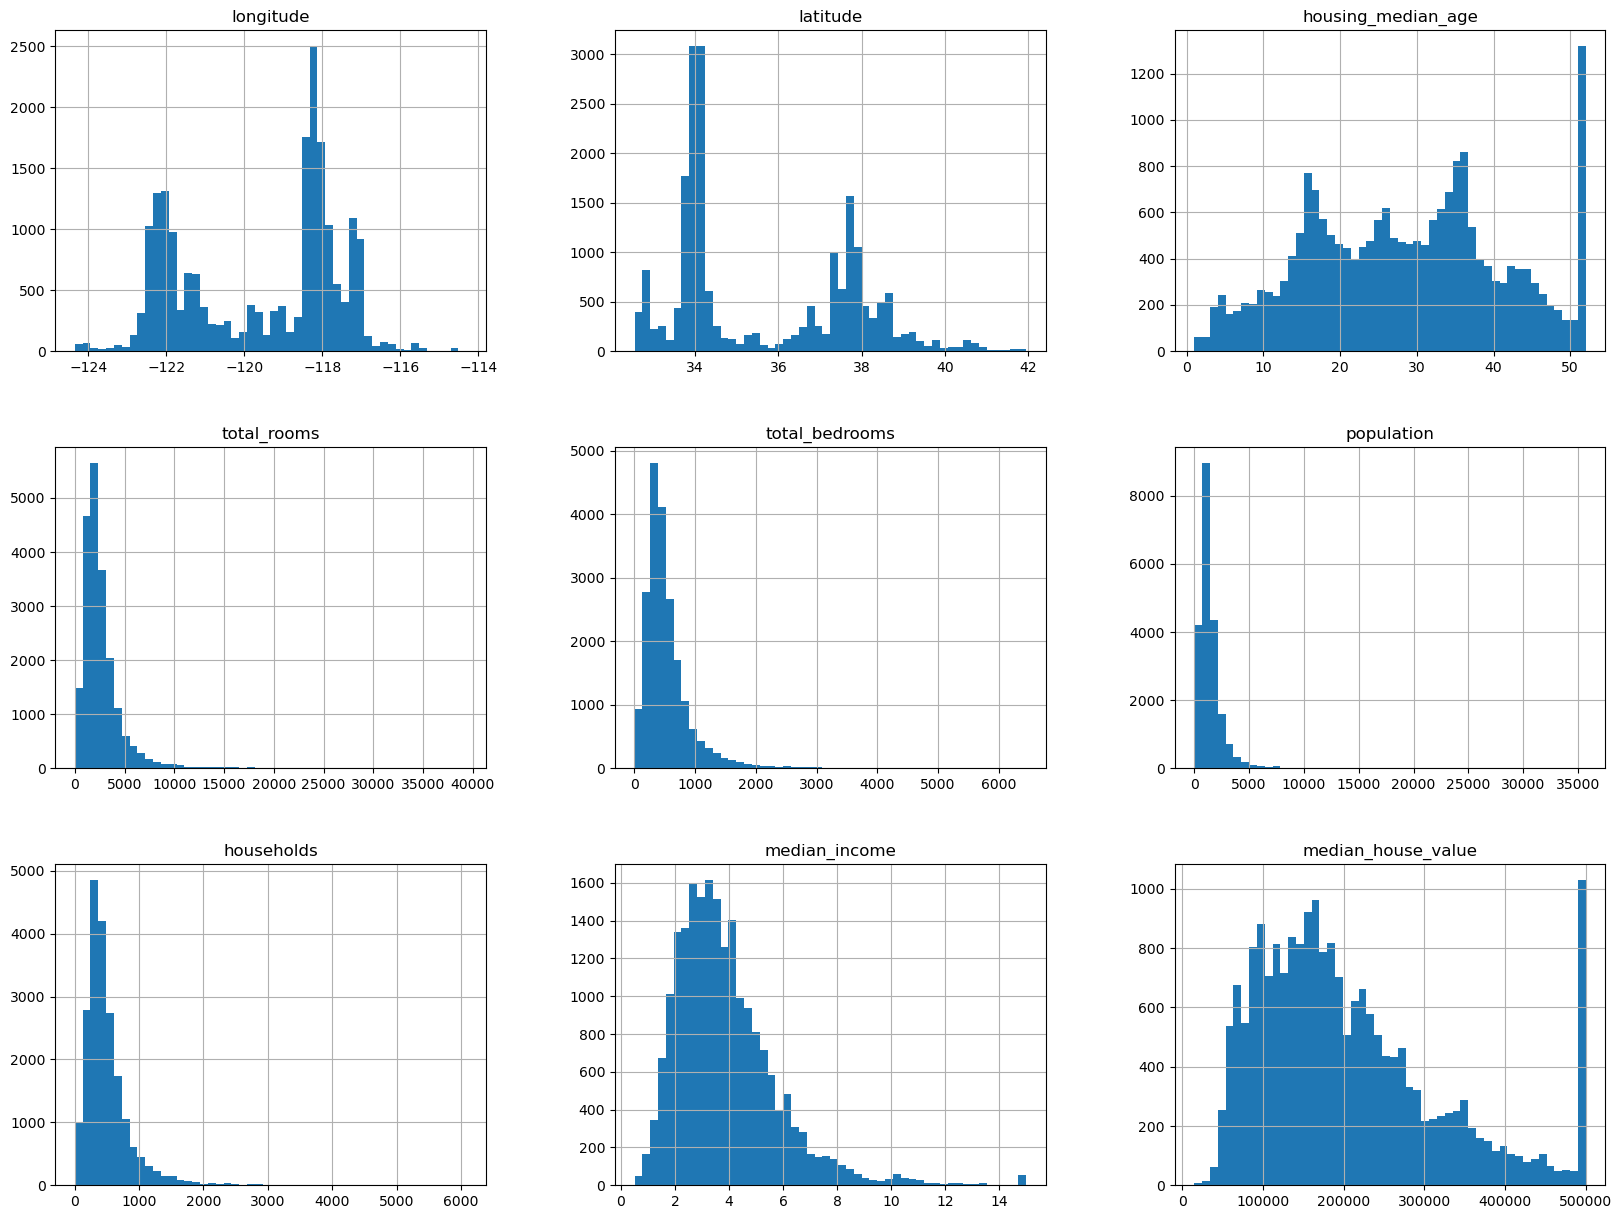

In [6]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))  # Corrected `len[data]` to `len(data)`
    test_set_size = int(len(data) * test_ratio)          # Fixed wrong `len(len(data)*test_ratio)`
    test_indices = shuffled_indices[:test_set_size]      # Fixed typo: `test_inidices` → `test_indices`
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Usage:
train_set, test_set = split_train_test(data=housing, test_ratio=0.2)


In [8]:
len(train_set)

16512

In [9]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [10]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5])

<Axes: >

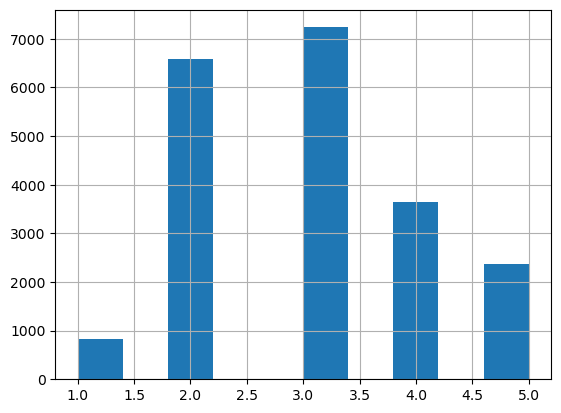

In [15]:
housing["income_cat"].hist()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [17]:
strat_train_set, strat_test_set = strat_splits[0]

In [18]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [22]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

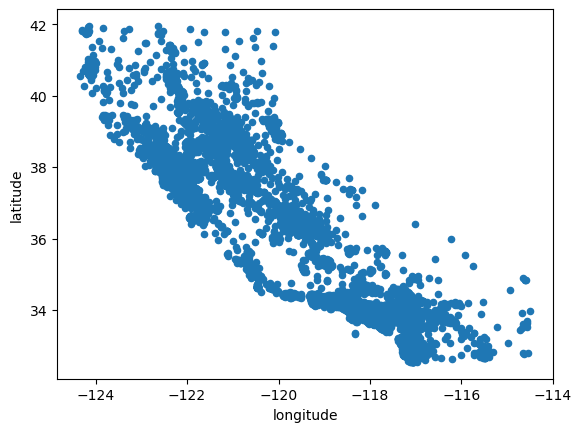

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

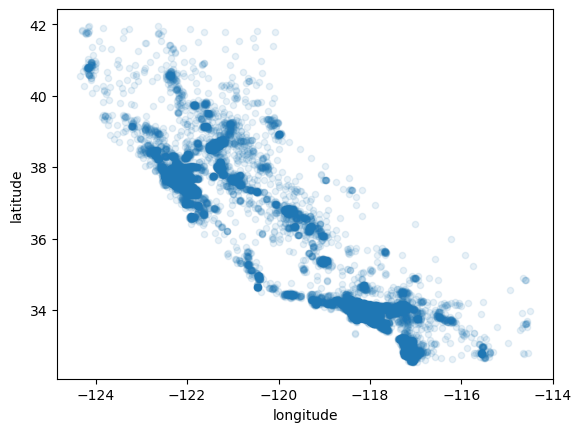

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)

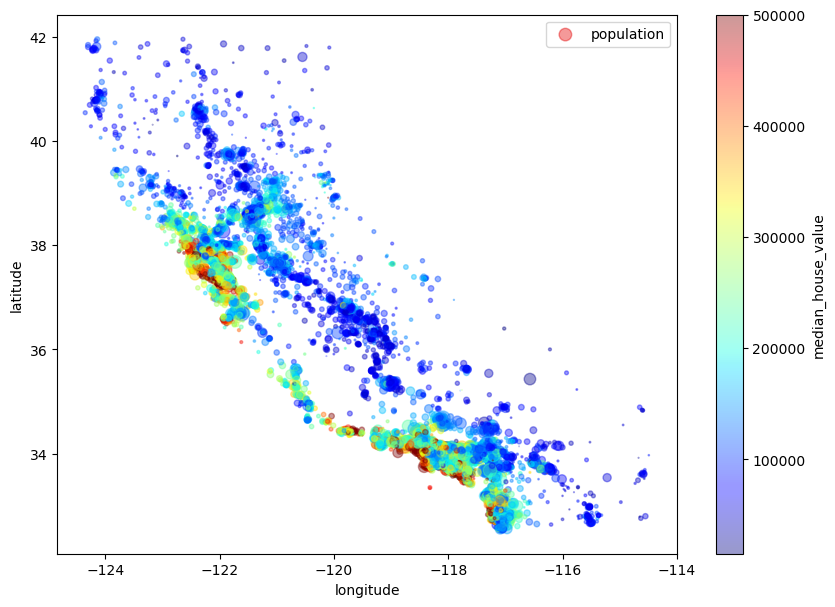

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [26]:
corr_matrix = housing.corr(numeric_only=True)

In [27]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

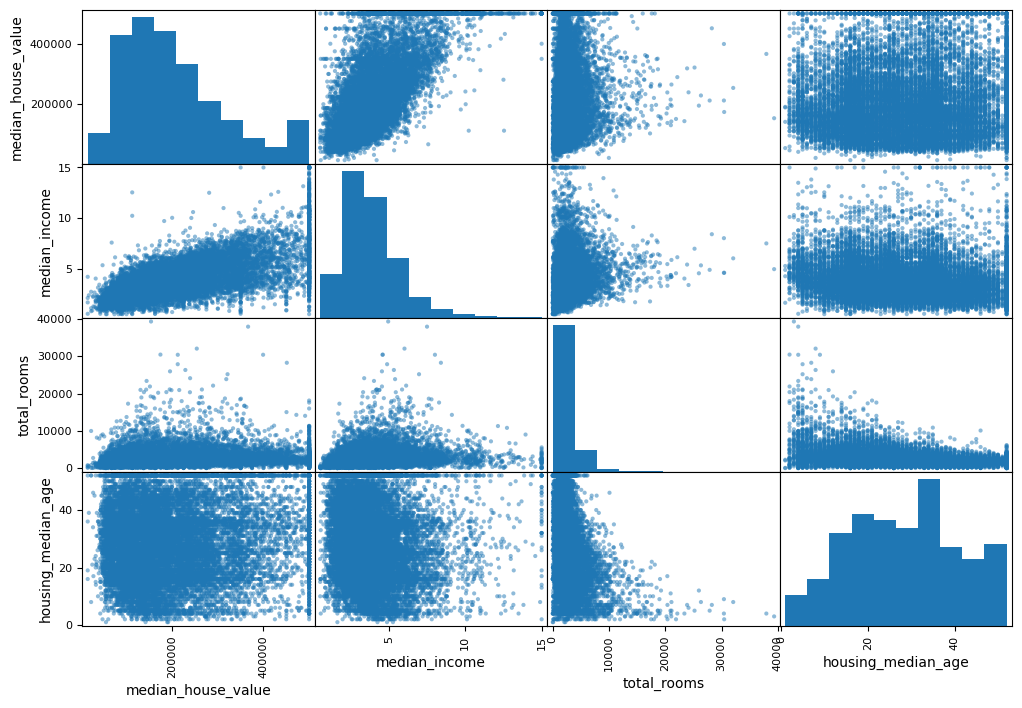

In [29]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

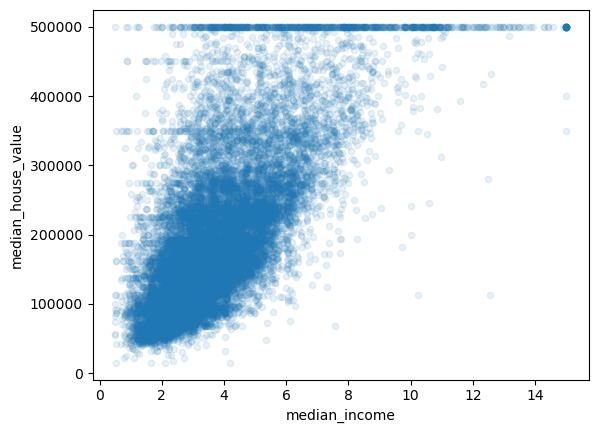

In [30]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

In [31]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [32]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [33]:
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

/tmp/ipykernel_11659/2198282036.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


In [34]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [35]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [36]:
X = imputer.transform(housing_num)

In [37]:
housing_tr = pd.DataFrame(X,columns = housing_num.columns,index = housing_num.index)

In [38]:
housing_cat = housing["ocean_proximity"].to_frame()
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [39]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# If you want to see first 10 rows:
(housing_cat_encoded[:10])


array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [40]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [41]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [42]:
#converting to dense numpy array
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [43]:
cat_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Indices for the columns
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing to fit

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Assuming CombinedAttributesAdder is your custom transformer
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributeAdder()),
    ('std_scaler', StandardScaler()),
])


In [46]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [47]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

In [48]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)


LinearRegression()

In [49]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [276608.27419651 333603.0303772  118237.5726011  108255.75159886
 308943.82732346]
Labels: [458300.0, 483800.0, 101700.0, 96100.0, 361800.0]


In [50]:
from sklearn.metrics import mean_squared_error
housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(67769.12117461127)

In [51]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor()

In [52]:
housing_predictions=  tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

In [53]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,scoring = "neg_mean_squared_error",cv= 10)
tree_rmse_scores = np.sqrt(-scores)

In [54]:
def display_scores(scores):
    print("Scores: ",scores)
    print("Mean : ",scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores:  [69100.1057108  69511.92853753 69084.51536016 75028.87490623
 69629.61248806 71001.23125024 72121.21701328 72669.57834858
 71085.12241067 70246.15800546]
Mean :  70947.8344031001
Standard deviation: 1794.317792013957


In [55]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)

In [56]:
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores:  [69717.57852026 66650.26617871 66488.43193213 70478.22519838
 66837.93229332 68220.31091521 66922.70445332 69700.47781664
 67122.26131607 67802.47918508]
Mean :  67994.06678091263
Standard deviation: 1394.9377015503203


In [57]:
#now lets try random forest regressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
display_scores(forest_rmse)


Scores:  18568.349111109248
Mean :  18568.349111109248
Standard deviation: 0.0


In [58]:
import joblib
joblib.dump(forest_reg, "forest_reg.pkl")
# and later...
my_model_loaded = joblib.load("forest_reg.pkl")

In [59]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [60]:
grid_predictions = grid_search.predict(housing_prepared)
grid_mse = mean_squared_error(housing_labels, grid_predictions)
grid_rmse = np.sqrt(grid_mse)
display_scores(grid_rmse)


Scores:  19419.274037649175
Mean :  19419.274037649175
Standard deviation: 0.0


In [61]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [62]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [63]:
feature_importances

array([7.36088360e-02, 6.86314978e-02, 4.32721822e-02, 1.75028754e-02,
       1.58044673e-02, 1.73514130e-02, 1.60944052e-02, 3.04288299e-01,
       5.80631766e-02, 1.09911703e-01, 9.07539575e-02, 7.17612521e-03,
       1.69809517e-01, 8.53470195e-05, 3.45040166e-03, 4.19579600e-03])

In [64]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3042882986346116), 'median_income'),
 (np.float64(0.169809517107185), 'INLAND'),
 (np.float64(0.10991170348661924), 'pop_per_hhold'),
 (np.float64(0.09075395750189179), 'bedrooms_per_room'),
 (np.float64(0.07360883602622688), 'longitude'),
 (np.float64(0.0686314977982558), 'latitude'),
 (np.float64(0.05806317656078508), 'rooms_per_hhold'),
 (np.float64(0.04327218216182102), 'housing_median_age'),
 (np.float64(0.017502875400785208), 'total_rooms'),
 (np.float64(0.017351413013777368), 'population'),
 (np.float64(0.01609440516527689), 'households'),
 (np.float64(0.015804467256508723), 'total_bedrooms'),
 (np.float64(0.0071761252074762924), '<1H OCEAN'),
 (np.float64(0.004195795995785009), 'NEAR OCEAN'),
 (np.float64(0.0034504016635209054), 'NEAR BAY'),
 (np.float64(8.534701947316591e-05), 'ISLAND')]

In [65]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [66]:
from scipy import stats
confidence = 0.95
squared_errors= (final_predictions-y_test)**2
np.sqrt(
    stats.t.interval(
        confidence,
        len(squared_errors)-1,
        loc=squared_errors.mean(),
        scale = stats.sem(squared_errors)
    )
)

array([47533.45422116, 52134.28746208])

# 